In [ ]:
%load_ext autoreload
%autoreload 2

# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

import numpy as np
from sdf import *

@sdf3
def gyroid(w = 3.14159, t=0):
    def f(p):
        q = w*p
        x, y, z = (q[:, i] for i in range(3))
        return (np.cos(x)*np.sin(y) + np.cos(y)*np.sin(z) + np.cos(z)*np.sin(x) - t)
    return f

In [ ]:
# Generate with skimage.measure.marching_cubes
f = sphere(1) & gyroid(w=12)
points = f.generate(step=0.01, verbose=True, method=1)
#write_binary_stl('gyroid_w12.stl', points)

In [11]:
from sdf.mesh import _cartesian_product, _estimate_bounds
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

def show_implicit_at_z(f, z_level=0, step=0.01, offset=30, nums=100, bounds=None, plot_gradient=False):
    dx, dy, dz = (step,)*3
    if bounds is None:
        bounds = _estimate_bounds(f)
    (x0, y0, z0), (x1, y1, z1) = bounds

    # X = np.arange(x0-offset*dx, x1+offset*dx, dx)
    # Y = np.arange(y0-offset*dy, y1+offset*dy, dy)
    # Z = np.arange(z0-offset*dz, z1+offset*dz, dz)

    X = np.linspace(x0-offset*dx, x1+offset*dx, nums)
    Y = np.linspace(y0-offset*dy, y1+offset*dy, nums)
    Z = np.array([z_level])

    P = _cartesian_product(X, Y, Z)
    sdf = f(P)
    sdf = sdf.reshape((nums, nums))
        
    if plot_gradient:
        gradient = np.linalg.norm(
            np.array(
                np.gradient(sdf, X[1]-X[0], Y[1]-Y[0])
            ),
            axis=0
        )
        _plot(sdf, gradient)
    else:
        _plot(sdf)

def show_sdf_at_z(stl_file, z_level=0, step=0.01, offset=30, nums=100, bounds=None, plot_gradient=False):
    from utils.libs import igl

    v,f = igl.read_triangle_mesh(stl_file)

    dx, dy, dz = (step,)*3
    if bounds is None:
        bv, bf = igl.bounding_box(v)
        bounds = (bv[0], bv[-1]) if np.mean(bv[0]) < np.mean(bv[-1]) else (bv[-1], bv[0])
    (x0, y0, z0), (x1, y1, z1) = bounds


    X = np.linspace(x0-offset*dx, x1+offset*dx, nums)
    Y = np.linspace(y0-offset*dy, y1+offset*dy, nums)
    Z = np.array([z_level])

    P = _cartesian_product(X, Y, Z)
    
    sdf, _, _ = igl.signed_distance(P, v, f, 4, return_normals=False)
    sdf = sdf.reshape((nums, nums))
    
    if plot_gradient:
        gradient = np.linalg.norm(
            np.array(
                np.gradient(sdf, X[1]-X[0], Y[1]-Y[0])
            ),
            axis=0
        )
        _plot(sdf, gradient)
    else:
        _plot(sdf)
  

def _plot(lvl_set, gradient=None):
    
    _, ax = plt.subplots()
    plt.pcolormesh(lvl_set, cmap='coolwarm', norm=CenteredNorm())
    plt.colorbar()
    ax.set_title('min=%.6f max=%.6f' % (np.min(lvl_set), np.max(lvl_set)))
    ax.tick_params(axis='both', which='major', labelsize=6)
    plt.show()

    if gradient is not None:
        _, ax = plt.subplots()
        plt.pcolormesh(gradient-1, cmap='coolwarm', norm=CenteredNorm())
        plt.colorbar()
        ax.set_title('min=%.6f max=%.6f' % (np.min(gradient-1), np.max(gradient-1)))
        ax.tick_params(axis='both', which='major', labelsize=6)
        #c.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.2f}'))
        #c.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.2f}'))
        plt.show()


min -0.565721, -0.565721, -0.565721
max 0.565722, 0.565722, 0.565722
step 0.01, 0.01, 0.01

248028 triangles in 0.427017 seconds


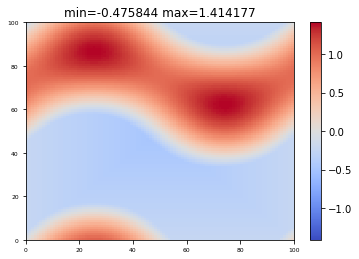

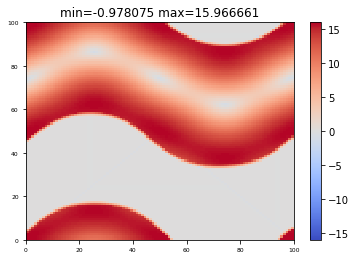

(array([-0.5, -0.5, -0.5]), array([0.5, 0.5, 0.5]))


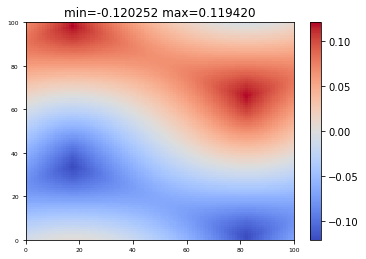

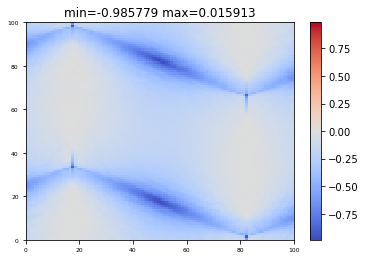

In [12]:
f = gyroid(w=12) & box(1)
f.save('tmp.stl')
show_implicit_at_z(f , offset=-30, plot_gradient=True)
show_sdf_at_z('tmp.stl', offset=-30, plot_gradient=True)

In [ ]:
f = sphere(1) & gyroid(w=12)
f.save('tmp.stl')
show_implicit_at_z(f , plot_gradient=True)
bounds = _estimate_bounds(f)
show_sdf_at_z('tmp.stl', bounds=bounds, nums=200, plot_gradient=True)